In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import json
import time
import numpy as np
import threading
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('C:\\Users\\David Palecek\\Documents\\Python_projects\\optan\\optan\\src'))
sys.path.insert(0, os.path.abspath('C:\\Users\\David Palecek\\Documents\\Python_projects\\optan\\optan\\src\\optan'))
sys.path.insert(0, os.path.abspath('C:\\Users\\David Palecek\\Documents\\Python_projects\\optan\\optan\\src\\optan\\examples'))
sys.path.insert(0, os.path.abspath('C:\\Users\\David Palecek\\Documents\\Python_projects\\optan\\optan'))
sys.path.insert(0, os.path.abspath('C:\\Users\\David Palecek\\Documents\\Python_projects\\optan'))

os.chdir('C:\\Users\\David Palecek\\Documents\\Python_projects\\optan')
# from optan.src import optan
from tomopy.recon.rotation import find_center, find_center_vo
import tomopy as tom

from skimage.transform import iradon, iradon_sart
from PIL import Image, ImageChops
from scipy.fftpack import fft, fftshift, ifft
# from radon_back_projection import Radon

ModuleNotFoundError: No module named 'cv2'

In [2]:
nbits = 8 # means 3 channels
channels = 3
os.getcwd()

'C:\\Users\\David Palecek\\Documents\\Python_projects\\optan'

In [3]:
fol = 'C:\\Users\\David Palecek\\Documents\\UAlg\\my_opt\\Data\\Scripts'
base_folder = os.path.join(fol, '..\\')

exp_folder = '\\230302-11-10-19\\'

In [4]:
os.chdir(''.join([base_folder, exp_folder]))

f = open('metadata.txt', "r")
metdat = json.loads(f.read())
file_list = os.listdir()
metdat

{'n_steps': 256,
 'n_sweeps': 1,
 'avg_per_frame': 5,
 'images_per_step': 1,
 'user notes': '8bit, transmission, f16 divergent, 3 layer of baking paper, plastic box, no LP, 1/297 exposure, 5avg per frame',
 'sweep_start': ['11-10-19'],
 'sweep_finish': ['11-15-18']}

In [5]:
global ENDING
if file_list[0][-3:] == '.gz':
    ENDING = '.gz'
    img = np.loadtxt(file_list[0])
elif file_list[0][-4:] == '.jpg':
    ENDING = '.jpg'
    img = cv2.imread(file_list[0], cv2.IMREAD_UNCHANGED)
elif file_list[0][-4:] == 'tiff':
    ENDING = '.tiff'
    # img = cv2.imread(file_list[0])
    img = cv2.imread(file_list[0], cv2.IMREAD_UNCHANGED)

full_scan = np.zeros((metdat['n_steps'], img.shape[0], img.shape[1]))
img.shape

(2048, 1536)

In [6]:
def fill_matrix(arr, img_idx, invert=True):
    for i in range(metdat['n_steps']):
        name = '0_' + str(i) + '_' + str(img_idx) + ENDING
        print(i, name, end='\r')
        if invert:
            img, mx =  get_image(name)
            arr[i, :] = mx-img
        else:
            arr[i, :] = get_image(name)[0]
    return arr
    
    
def get_image(name):
    if ENDING == '.jpg':
        img = cv2.imread(name)
        img = img[:,:,0]
    elif ENDING == '.tiff':
        if nbits == 8:
            img = cv2.imread(name)
        else:
            img = cv2.imread(name, cv2.IMREAD_UNCHANGED)
        # img = img[:,:,0]
    else:
        img = np.loadtxt(name)
    # img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img[:,:,0], np.amax(img[:,:,0])

## Real stuff

In [7]:
n_steps = metdat['n_steps']
full_scan = fill_matrix(full_scan, 0, invert=True)

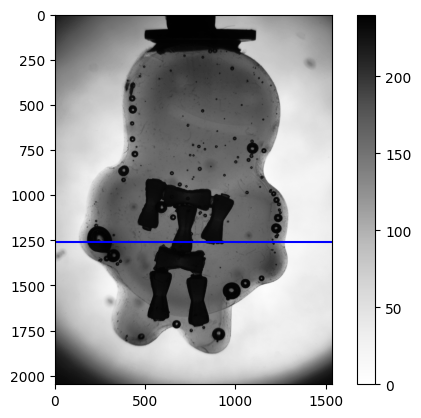

In [42]:
plt.imshow(full_scan[0,:],cmap=plt.cm.Greys)
plt.axhline(y = 1260, color = 'b', label = 'axvline - full height')
plt.savefig('image.png')
plt.colorbar()
plt.show()

## Binning

In [16]:
# for threading
def func2(idx, arr_in, arr_out):
    arr_out[idx] = arr_in[idx].reshape(arr_in.shape[1]//2, 2, arr_in.shape[2]//2, 2).mean(3).mean(1)

# not threaded, 27s
# beg = time.perf_counter()
# full_bin2 = np.zeros((full_scan.shape[0], full_scan.shape[1]//2, full_scan.shape[2]//2), dtype=np.int8)
# for i in range(n_steps):
#     print(i, end='\r')
#     full_bin2[i] = full_scan[i].reshape(full_scan.shape[1]//2, 2, full_scan.shape[2]//2, 2).mean(3).mean(1)
# end = time.perf_counter()
# print(end-beg)

In [43]:
beg = time.perf_counter()
full_bin2 = np.zeros((full_scan.shape[0], full_scan.shape[1]//2, full_scan.shape[2]//2), dtype=np.int16)
for i in range(n_steps):
    threadProcess = threading.Thread(name='simplethread', target=func2, args=[i, full_scan, full_bin2])
    threadProcess.daemon = True
    threadProcess.start()
end = time.perf_counter()
print(end-beg)

2.211809399999993


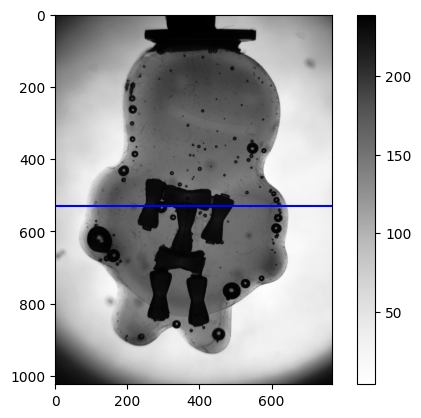

(256, 1024, 768)

In [44]:
plt.imshow(full_bin2[0,:],cmap=plt.cm.Greys)
plt.axhline(y = 530, color = 'b', label = 'axvline - full height')
plt.savefig('image.png')
plt.colorbar()
plt.show()
full_bin2.shape

In [45]:
theta = np.linspace(0., 360., n_steps, endpoint=False)
idx = 610
print(len(theta))

256


In [46]:
fbp1 = iradon(full_bin2[:, idx, :].T, theta=theta[:], filter_name='ramp')
fbp2 = iradon(full_bin2[:128, idx, :].T, theta=theta[:128], filter_name='ramp')

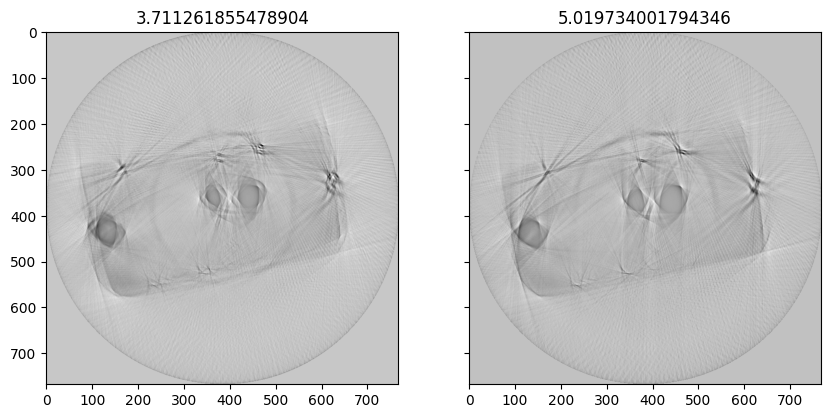

In [47]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10, 6))
ax[0].imshow(fbp1,cmap=plt.cm.Greys)#np.log(abs(a)))
ax[0].set_title(np.amax(fbp1))

ax[1].imshow(fbp2,cmap=plt.cm.Greys)
ax[1].set_title(np.amax(fbp2))

plt.show()

In [48]:
theta = np.linspace(
                    0., 360.,
                    n_steps, endpoint=False
                    ) / 360. * (2 * np.pi)
center = find_center(full_bin2[:128], theta=theta[:128], ind=idx, init=384, ratio=2)
print(center)

[389.1]


In [49]:
center = find_center_vo(full_bin2[:128], ind=idx, ratio=0.5)
print(center)

377.75


## Finding center every 200 pixels

In [50]:
beg = time.perf_counter()
steps = full_bin2.shape[1]//200
center = []
for i in range(steps):
    print(i)
    center.append(find_center_vo(full_bin2[:128], ind=i*200, ratio=0.5))
end = time.perf_counter()
print(end-beg)

0
1
2
3
4
34.54410060000009


In [51]:
center

[378.0, 377.25, 376.5, 377.25, 378.25]

In [65]:
def find_center_thread(idx, arr, list_out):
    list_out[idx] = find_center_vo(arr[:128], ind=idx*200, ratio=0.5)
    # print(find_center_vo(arr[:128], ind=idx*200, ratio=0.5))

def func3(idx, arr):
    print(find_center_vo(arr[:128], ind=idx*200, ratio=0.5))

In [70]:
# this does not work, dunno why
# beg = time.perf_counter()
# steps = full_bin2.shape[1]//200
# center = np.zeros(steps)

# for i in range(steps):
#     print(i)
#     threadProcess = threading.Thread(name='simplethread',
#                                      target=find_center_thread,
#                                      args=[i, full_bin2, center])
#     # threadProcess.daemon = True
#     threadProcess.start()
# end = time.perf_counter()
# print(end-beg)

## Threading recon

In [85]:
def recon_thread(idx, arr, arr_out):
    a = tom.recon(arr[:,idx:idx+1,:], theta, center=378,
                  sinogram_order=False, algorithm='art')
    arr_out[idx] = a.squeeze()

r1 = tom.recon(full_bin2[:,idx:idx+1,:], theta, center=378,
              sinogram_order=False, algorithm='art')#, filter_name='cosine')

In [102]:
beg = time.perf_counter()
full_bin2_recon = np.zeros((full_bin2.shape[1], *r1.squeeze().shape))
for i in range(full_bin2.shape[1]):
    print(i, end='\r')
    threadProcess = threading.Thread(name='simplethread', target=recon_thread, args=[i, full_bin2, full_bin2_recon])
    threadProcess.daemon = True
    threadProcess.start()
end = time.perf_counter()
print(end-beg)

344.6105282000003


In [103]:
full_bin2_recon.shape

(1024, 768, 768)

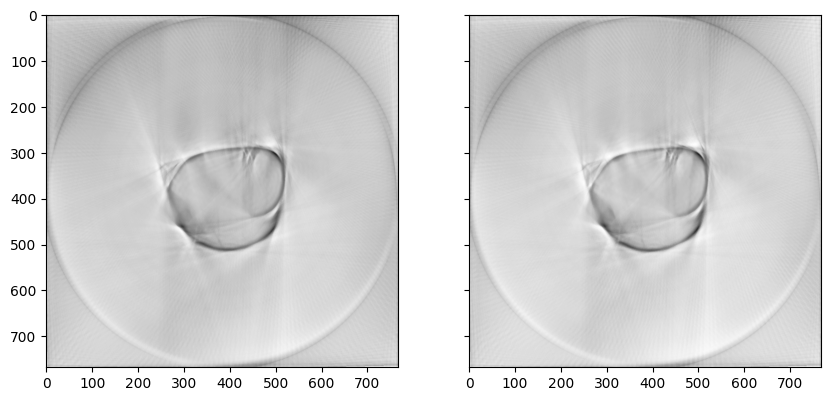

In [107]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10, 6))
ax[0].imshow(full_bin2_recon[99],cmap=plt.cm.Greys)#np.log(abs(a)))
# ax[0].set_title(np.amax(fbp1))

ax[1].imshow(full_bin2_recon[100],cmap=plt.cm.Greys)
# ax[1].set_title(np.amax(fbp2))

plt.show()

In [111]:
np.amax(full_bin2_recon), np.amin(full_bin2_recon)

(9.933884620666504, -6.522325038909912)

In [112]:
to_save = full_bin2_recon.astype(np.float16)

In [113]:
np.amax(to_save), np.amin(to_save)

(9.94, -6.523)

In [114]:
np.save('transmission_noLP', to_save)

In [106]:
os.getcwd()

'C:\\Users\\David Palecek\\Documents\\UAlg\\my_opt\\Data\\230302-11-10-19'

In [109]:
np.round([1.35234523452345, 8.9823642314], 4)

array([1.3523, 8.9824])

In [ ]:

r1 = tom.recon(full_bin2[:,idx:idx+1,:], theta, center=378,
                  sinogram_order=False, algorithm='art')#, filter_name='cosine')
r2 = tom.recon(full_bin2[:,idx:idx+1,:], theta, center=378.75,
              sinogram_order=False, algorithm='art')#, filter_name='cosine')
r3= tom.recon(full_bin2[:,idx:idx+1,:], theta, center=376,
              sinogram_order=False, algorithm='art')#, filter_name='cosine')

In [ ]:
r1.shape, full_scan.shape

((1, 768, 768), (256, 2048, 1536))

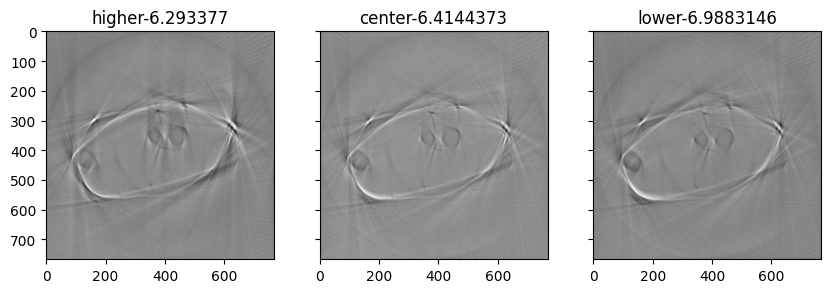

In [ ]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(10, 6))
ax[0].imshow(r1[0],cmap=plt.cm.Greys)#np.log(abs(a)))
ax[0].set_title('higher' + str(np.amin(r1)))

ax[1].imshow(r2[0],cmap=plt.cm.Greys)
ax[1].set_title('center' + str(np.amin(r2)))

ax[2].imshow(r3[0],cmap=plt.cm.Greys)
ax[2].set_title('lower' + str(np.amin(r3)))

plt.show()

## Doing the whole matrix

In [ ]:
theta = np.linspace(
            0., 360.,
            128, endpoint=False
            ) / 360. * (2 * np.pi)


In [ ]:
exp.recon_iradon(idx)

IndexError: index 700 is out of bounds for axis 0 with size 128

In [ ]:
center = find_center(exp.data, theta=theta[:], ind=idx)
print(center)

[427.5]


In [ ]:
center = tom.find_center_vo(
            exp.data,
            ind=idx,
            smin=-100, smax=100)
print(center)

405.25


In [ ]:
r = tom.recon(exp.data[:,idx-5:idx+5,:], theta, center=center, algorithm='mlem')

In [ ]:
r.shape

(10, 800, 800)

In [ ]:
import matplotlib.pyplot as plt

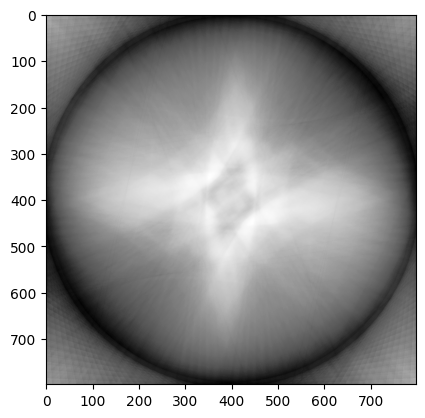

In [ ]:
cut = 1
plt.imshow(r[5, cut:-cut, cut:-cut], cmap=plt.cm.Greys)